<h2> Machine Learning for crop detection</h2>

In this notebook machine learning techniquey will be used to predict crops on fields based on their spectral signature. The "ground truth data" will be used from the [US Cropland Data Layer](https://nassgeodata.gmu.edu/CropScape/). From this layer the 5 most common crops for 2019 in the area of interest in North Dakota were chosen and downloaded as raster masks.

The training date will be Sentinel-2 data of 2019. The band 1-9 are being used.

A Logistic Regression, Decision Tree Classifier and a Random Forest Classifier will be trained on the data to see how well the 9-band Sentinel-2 Scene performs to detect types of crop.

In [1]:
# necessary Imports
import os
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib as mpl
from matplotlib import cm
from IPython.display import Image

from helper_functions import RasterHelper, LegendHelper
# geodata specific imports
import gdal
import rasterio
from rasterio.mask import mask

from geojson import Polygon

In [2]:
helper = RasterHelper()
legend_helper = LegendHelper()

In [6]:
# set aoi for clipping sentinel data and Labels to same extent
aoi= [{'type': 'Polygon', 'coordinates': [[[-10821406, 6029867], [-10821406, 6067979], [-10768297, 6067979], [-10768297, 6029867], [-10821406, 6029867]]]}]

In [4]:
croplist = ["Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]

<h2> Load Reference Data </h2>

The US Cropland Data Layer used as reference data in this notebook seems to be derrived from Satellite data as well, which makes the analysis a bit less reliable, as the "ground truth" might be falsely classifed as well and that error will stay with the data as we use for training and validation. In the [Classification Folder](sample_data/NorthDakota/classification) There are individual Tif files for each crop, showing the acres in which that crop is harvested

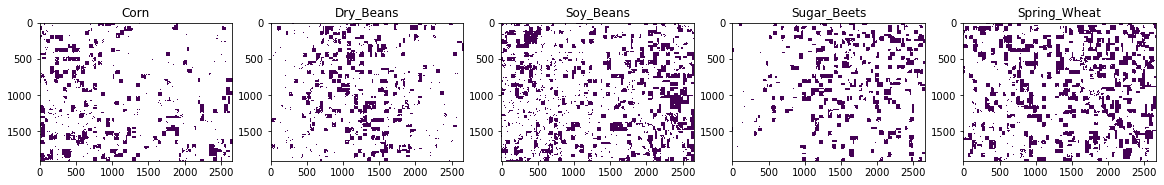

In [7]:
crop_arrays = []
fig, axes = plt.subplots(1,5, figsize = (20,5))
for i, crop in enumerate(croplist):
    raster = rasterio.open(f'sample_data/NorthDakota/classification/{crop}_3857.tif')

    out_img, out_transform = mask(raster, shapes=aoi, crop=True)
    array = out_img[0]
    array = np.where(array == 0, np.nan, array)
    array = np.where(array == np.nanmean(array), i+1, np.nan)
    crop_arrays.append(array)
    axes[i].imshow(array)
    axes[i].set_title(croplist[i])


crop_array = np.array(crop_arrays)

<h3> Merge Crops to singel image containing Labels</h3>

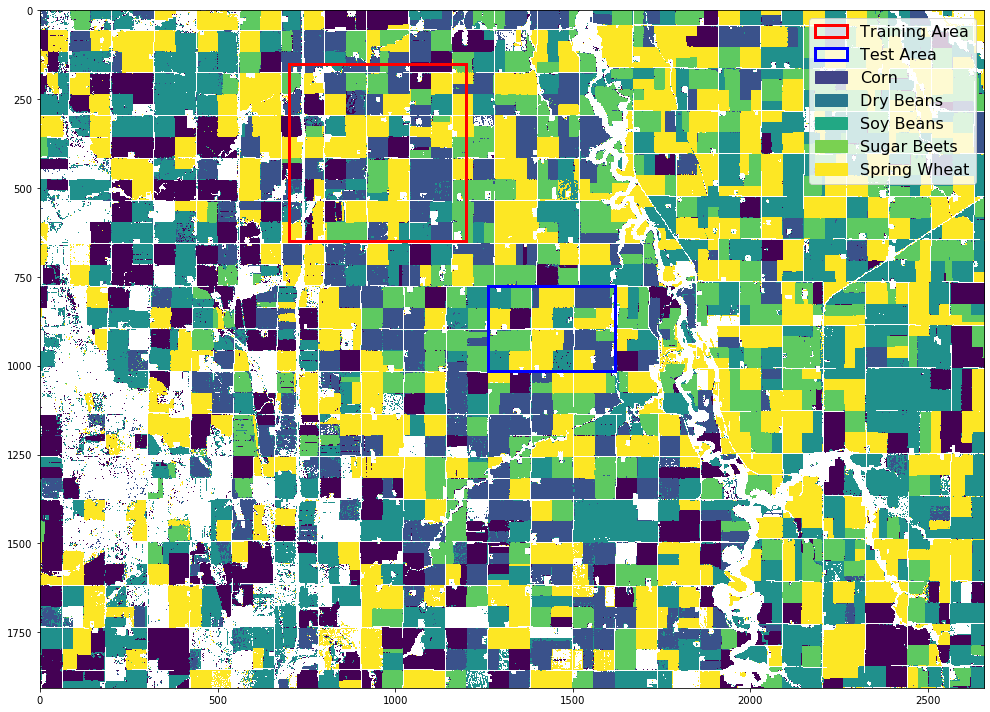

In [8]:
cropsum = np.nansum(crop_array, axis=0)
cropsum = np.where(cropsum == 0, np.nan, cropsum)

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(cropsum)
rect_train = patches.Rectangle((700,150), 500, 500, linewidth=3, edgecolor='r', facecolor='none')
rect_test = patches.Rectangle((1260,775), 360, 240, linewidth=3, edgecolor='b', facecolor='none')
ax.add_patch(rect_train)
ax.add_patch(rect_test)

plt.legend(handles=legend_helper.patch_legend, prop={'size': 16})
plt.tight_layout()

<h3> Open Sentinel Scenes</h3>

In [9]:
# open data sets
dir = "sample_data/NorthDakota/Sentinel"
# loop over directory and open all single band tiffs
helper = RasterHelper()
multiband_array = helper.open_multiband_scene(directory=dir, aoi=aoi)

Files were loaded sucessfully. 


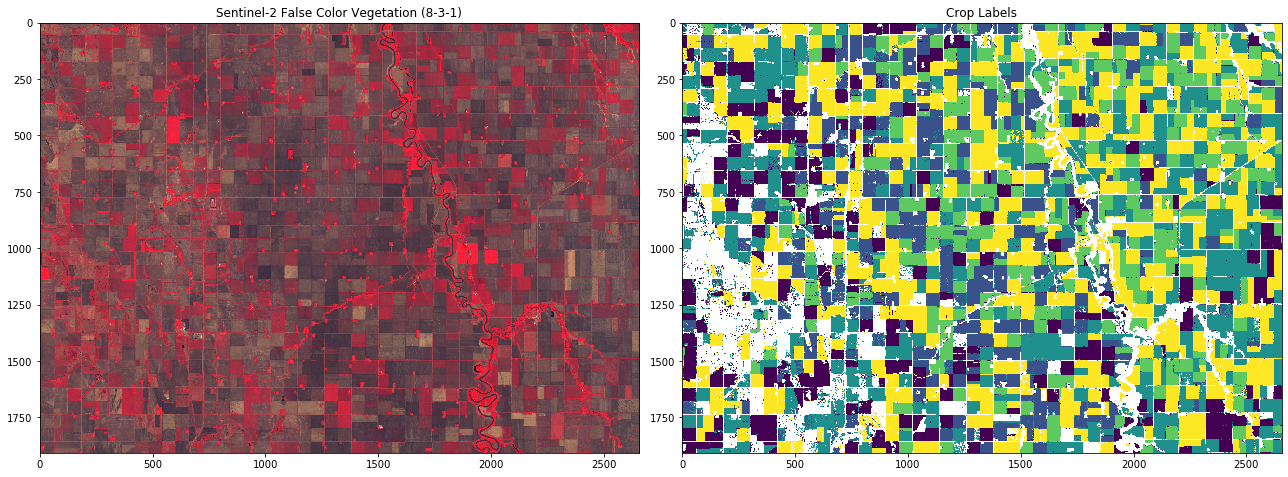

In [10]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
#plot false color Vegetation image
axes[0].imshow(np.dstack([multiband_array[0][7],multiband_array[0][3],multiband_array[0][1]]))
axes[1].imshow(cropsum)
axes[0].set_title("Sentinel-2 False Color Vegetation (8-3-1)")
axes[1].set_title("Crop Labels")
plt.tight_layout()

<h2> Create Training and Validation Sets</h2>

The red and blue aquers in the figure above representing the training and validation area, will be extracted as training data and validation area. Therefore all arrays in the Sentinel Seneces (18 in total) must be sliced to the extents, as well as the label map.

<h4> Create Training Data</h4>

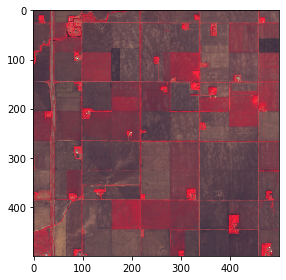

In [11]:
# reduce crop labels to training set
cropsum_train = cropsum[150:650, 700:1200]
cropsum_train.shape

# reduce Sentinel Scene to smaller region
small_array = []
for multiband in multiband_array:
    month = []

    for array in multiband:

        cutout = array[150:650, 700:1200]
        month.append(cutout)

    small_array.append(month)

small_array_train = np.array(small_array)
plt.imshow(np.dstack([small_array_train[0][7],small_array_train[0][3],small_array_train[0][1]]))
plt.tight_layout()

<h4> Create Validation Data</h4>

(240, 360)


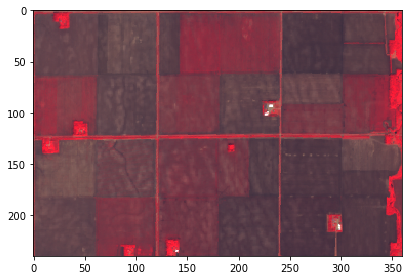

In [12]:
# Reduce Date to test set
cropsum_test = cropsum[775:1015, 1260:1620]
cropsum_test = np.nan_to_num(cropsum_test)
print(cropsum_test.shape)

# reduce Sentinel Scenes to smaller region
small_array = []
for multiband in multiband_array:
    month = []

    for array in multiband:

        cutout = array[775:1015, 1260:1620]
        month.append(cutout)

    small_array.append(month)

small_array_test = np.array(small_array)

plt.imshow(np.dstack([small_array_test[0][7],small_array_test[0][3],small_array_test[0][1]]))
plt.tight_layout()


<h2> Prepare data for Machine Learning</h2>

In [13]:
import pandas as pd

Reshape array to shape nx9 representing one pixel per row and all 9 bands per pixel. repeat for both Sentinel Scenens (June and September) and Label map (nx1). Then Concat all columns to train DataFrame and Test Data Frame


In [14]:
# reshape to one row per pixel
signature_array_June_train = small_array_train[0].T.reshape(-1,9)
signature_array_Sept_train = small_array_train[1].T.reshape(-1,9)
label_array_train = cropsum_train.T.reshape(-1,1)

signature_array_June_test = small_array_test[0].T.reshape(-1,9)
signature_array_Sept_test = small_array_test[1].T.reshape(-1,9)
label_array_test = cropsum_test.T.reshape(-1,1)

In [15]:
# create pandas data frames
df_1_train = pd.DataFrame(signature_array_June_train, columns=['Jun_B1','Jun_B2','Jun_B3','Jun_B4','Jun_B5','Jun_B6','Jun_B7','Jun_B8','Jun_B9'])
df_2_train = pd.DataFrame(signature_array_Sept_train, columns=['Sep_B1','Sep_B2','Sep_B3','Sep_B4','Sep_B5','Sep_B6','Sep_B7','Sep_B8','Sep_B9'])
label_train = pd.DataFrame(label_array_train, columns=['Label'])

df_1_test = pd.DataFrame(signature_array_June_test, columns=['Jun_B1','Jun_B2','Jun_B3','Jun_B4','Jun_B5','Jun_B6','Jun_B7','Jun_B8','Jun_B9'])
df_2_test = pd.DataFrame(signature_array_Sept_test, columns=['Sep_B1','Sep_B2','Sep_B3','Sep_B4','Sep_B5','Sep_B6','Sep_B7','Sep_B8','Sep_B9'])
label_test = pd.DataFrame(label_array_test, columns=['Label'])

<h2> Train Models on spectral Signatures of single Month (June) </h2>

In [33]:
# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Sklearn utility functions
from sklearn.metrics import accuracy_score

In [30]:
# concat dfs to training set and test set and replace NaN values in label with class 0
df_train = pd.concat([df_1_train, label_train], axis=1)
df_train["Label"] = df_train["Label"].fillna(0)
df_test = pd.concat([df_1_test, label_test], axis=1)
df_test["Label"] = df_test["Label"].fillna(0)
df_train.head()

Jun_B1    Jun_B2    Jun_B3    Jun_B4    Jun_B5    Jun_B6    Jun_B7  \
0  0.501777  0.296254  0.251255  0.265003  0.293751  0.332494  0.363500   
1  0.500708  0.298497  0.251255  0.265995  0.293248  0.332006  0.362493   
2  0.499640  0.300008  0.252506  0.265248  0.290257  0.330007  0.363745   
3  0.498572  0.290745  0.246754  0.258000  0.283497  0.325505  0.361501   
4  0.497504  0.292500  0.245747  0.252995  0.279255  0.321752  0.357000   

     Jun_B8    Jun_B9  Label  
0  0.379995  0.303437    2.0  
1  0.383993  0.302672    2.0  
2  0.382254  0.301095    2.0  
3  0.368505  0.299541    2.0  
4  0.370993  0.297964    2.0

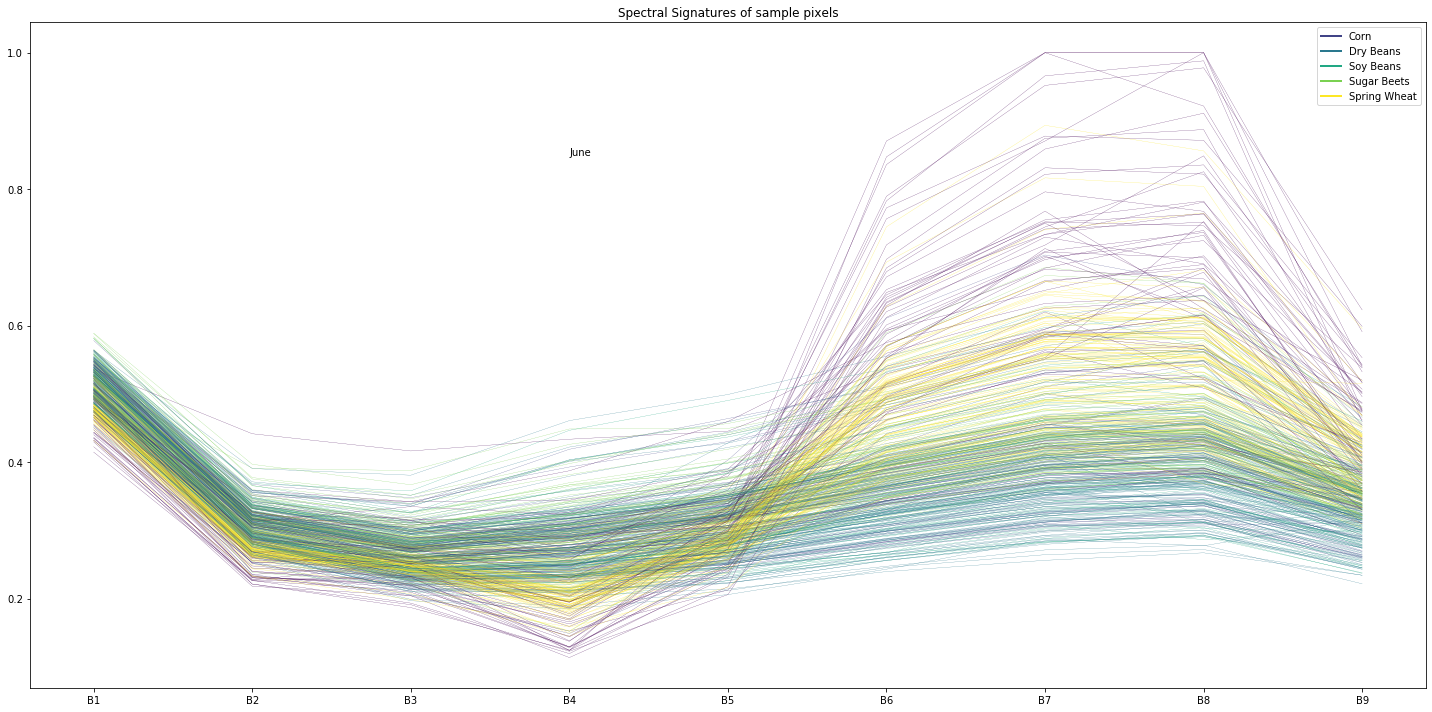

In [32]:
# plot sample

sample = df_train.sample(n=500)
sample_X = np.array(sample.drop(['Label'], axis=1))
sample_y = sample["Label"]

labelist = ["Nan", "Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]

fig, ax = plt.subplots(figsize=(20, 10))
for y, f in zip(sample_X, sample_y):
    ax.plot(range(9), y,  c=cm.viridis(f/5), linewidth=0.2 )

plt.text(3,0.85, "June")
plt.xticks(np.arange(9), ('B1','B2','B3','B4','B5','B6','B7','B8','B9'))
plt.title("Spectral Signatures of sample pixels")
plt.legend(handles=legend_helper.line_legend, loc='top-left')
plt.tight_layout()

In [34]:

# Create classification tree
my_tree_mod = DecisionTreeClassifier(criterion = 'gini')
my_tree_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_tree_mod_acc = accuracy_score(y_val, my_tree_mod.predict(X_val))
print('Classification tree accuracy Single Month:', my_tree_mod_acc)


Classification tree accuracy: 0.5481018518518519


In [36]:
# Create classification tree
my_tree_mod = DecisionTreeClassifier(criterion = 'gini')
my_tree_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_tree_mod_acc = accuracy_score(y_val, my_tree_mod.predict(X_val))
print('Classification tree accuracy Single Month:', my_tree_mod_acc)

Classification tree accuracy: 0.5489467592592593


In [35]:
# Create random forest
my_forest_mod = RandomForestClassifier(criterion = 'gini', n_estimators = 500, n_jobs=-2)
my_forest_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_forest_mod_acc = accuracy_score(y_val, my_forest_mod.predict(X_val))
print('Random forest accuracy:', my_forest_mod_acc)

Random forest accuracy: 0.628275462962963


The Low values of accuracy indicate, that the models are having a hard time to distinguish the different crops based on the spectral signature of a singel month. Lets see if adding the developent in September, creates a better base for classification

<h2> Training Models und 2 Months data</h2>

In [37]:
# concat dfs to training set and test set and replace NaN values in label with class 0
df_train = pd.concat([df_1_train, df_2_train, label_train], axis=1)
df_train["Label"] = df_train["Label"].fillna(0)
df_test = pd.concat([df_1_test, df_2_test, label_test], axis=1)
df_test["Label"] = df_test["Label"].fillna(0)
df_train.head()

Jun_B1    Jun_B2    Jun_B3    Jun_B4    Jun_B5    Jun_B6    Jun_B7  \
0  0.501777  0.296254  0.251255  0.265003  0.293751  0.332494  0.363500   
1  0.500708  0.298497  0.251255  0.265995  0.293248  0.332006  0.362493   
2  0.499640  0.300008  0.252506  0.265248  0.290257  0.330007  0.363745   
3  0.498572  0.290745  0.246754  0.258000  0.283497  0.325505  0.361501   
4  0.497504  0.292500  0.245747  0.252995  0.279255  0.321752  0.357000   

     Jun_B8    Jun_B9    Sep_B1    Sep_B2    Sep_B3    Sep_B4    Sep_B5  \
0  0.379995  0.303437  0.487583  0.277256  0.235996  0.244007  0.249744   
1  0.383993  0.302672  0.486475  0.274006  0.234745  0.241001  0.249500   
2  0.382254  0.301095  0.485368  0.272251  0.233997  0.241245  0.250507   
3  0.368505  0.299541  0.484261  0.272251  0.233753  0.239002  0.248753   
4  0.370993  0.297964  0.483154  0.269245  0.231006  0.236500  0.250996   

     Sep_B6    Sep_B7    Sep_B8    Sep_B9  Label  
0  0.283253  0.326497  0.309255  0.361963    2.0  
1  0.284001  0.323507  0.314244  0.367769    2.0  
2  0.283497  0.318746  0.320500  0.373575    2.0  
3  0.284245  0.320256  0.314748  0.378177    2.0  
4  0.285756  0.326253  0.317006  0.381647    2.0

In [38]:
# split into independent and dependent variables
X_train = df_train.drop(['Label'], axis=1)
y_train = df_train["Label"]

X_val = df_test.drop(['Label'], axis=1)
y_val = df_test["Label"]



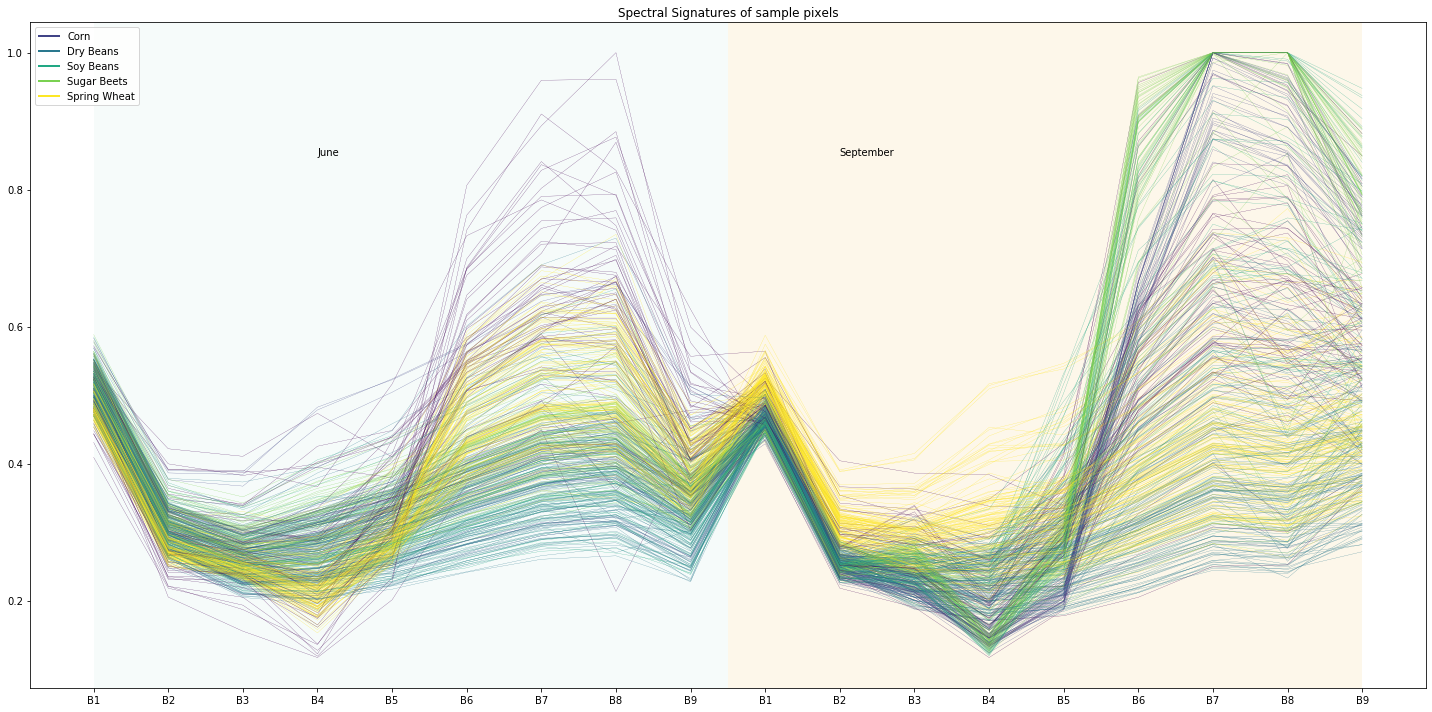

In [39]:
# plot sample

sample = df_train.sample(n=500)
sample_X = np.array(sample.drop(['Label'], axis=1))
sample_y = sample["Label"]

labelist = ["Nan", "Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]

fig, ax = plt.subplots(figsize=(20, 10))
for y, f in zip(sample_X, sample_y):
    ax.plot(range(18), y,  c=cm.viridis(f/5), linewidth=0.2 )

plt.axvspan(0, 8.5, facecolor='#d4ebe7', alpha=0.2)
plt.axvspan(8.5, 17, facecolor='#f7d998', alpha=0.2)
plt.text(3,0.85, "June")
plt.text(10,0.85, "September")
plt.xticks(np.arange(18), ('B1','B2','B3','B4','B5','B6','B7','B8','B9','B1','B2','B3','B4','B5','B6','B7','B8','B9'))
plt.title("Spectral Signatures of sample pixels")
plt.legend(handles=legend_helper.line_legend, loc='top-left')
plt.tight_layout()

<h2> Train Models </h2>

In [40]:

# Create a logistic regression model
my_reg_mod = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear')
my_reg_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_reg_mod_acc = accuracy_score(y_val, my_reg_mod.predict(X_val))
print('Logistic regression accuracy:', my_reg_mod_acc)


Logistic regression accuracy: 0.8493055555555555


In [41]:

# Create classification tree
my_tree_mod = DecisionTreeClassifier(criterion = 'gini')
my_tree_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_tree_mod_acc = accuracy_score(y_val, my_tree_mod.predict(X_val))
print('Classification tree accuracy:', my_tree_mod_acc)


Classification tree accuracy: 0.7625231481481481


In [42]:
# Create random forest
my_forest_mod = RandomForestClassifier(criterion = 'gini', n_estimators = 500, n_jobs=-2)
my_forest_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_forest_mod_acc = accuracy_score(y_val, my_forest_mod.predict(X_val))
print('Random forest accuracy:', my_forest_mod_acc)

Random forest accuracy: 0.8695949074074074


<h3> Predict Test Area</h3>

In [43]:
pred_LR = my_reg_mod.predict(X_val)
pred_DT = my_tree_mod.predict(X_val)
pred_RF = my_forest_mod.predict(X_val)

<h4> Reshape prediction Array to image shape</h4>

In [44]:
LR_array = np.reshape(np.array(pred_LR), (cropsum_test.shape[1], cropsum_test.shape[0]))
LR_img = np.flip(np.rot90(LR_array, 3), 1)

DT_array = np.reshape(np.array(pred_DT), (cropsum_test.shape[1], cropsum_test.shape[0]))
DT_img = np.flip(np.rot90(DT_array, 3), 1)

RF_array = np.reshape(np.array(pred_RF), (cropsum_test.shape[1], cropsum_test.shape[0]))
RF_img = np.flip(np.rot90(RF_array, 3), 1)

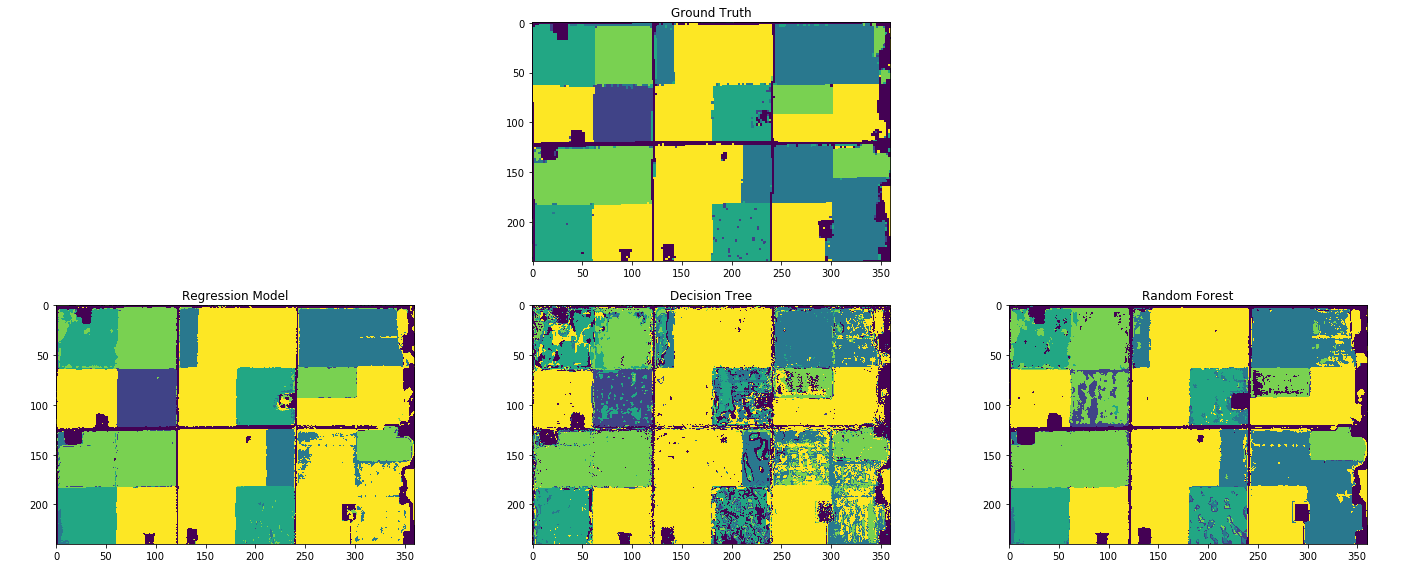

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20,8))
axes[0,1].imshow(cropsum_test)
axes[1,0].imshow(LR_img)
axes[1,1].imshow(DT_img)
axes[1,2].imshow(RF_img)
axes[0,1].set_title('Ground Truth')
axes[1,0].set_title('Regression Model')
axes[1,1].set_title('Decision Tree')
axes[1,2].set_title('Random Forest')
axes[0,0].set_axis_off()
axes[0,2].set_axis_off()
plt.tight_layout()

<h2> Conclusion </h2>
Using the 2 months instead of just one delivers much better results in terms of accuracy. Also looking at the predicted crops in the test area, the logistic regression and the Random Forest Classifier show very promising results. the Decision Tree Classifier is a bit confised by some acres. The problems in prediciton might also result from errors in the training data, so the same test should be conducted with perfect training data in order to see the actual advantages of each Classfier

In [58]:
full_prediction = my_reg_mod.predict(pd.concat([pd.DataFrame(np.nan_to_num(multiband_array[0].T.reshape(-1,9))), pd.DataFrame(np.nan_to_num(multiband_array[1].T.reshape(-1,9))) ], axis=1))

In [62]:
full_array = np.reshape(np.array(full_prediction), (multiband_array[0][0].shape[1], multiband_array[0][0].shape[0]))
full_img = np.flip(np.rot90(full_array, 3), 1)

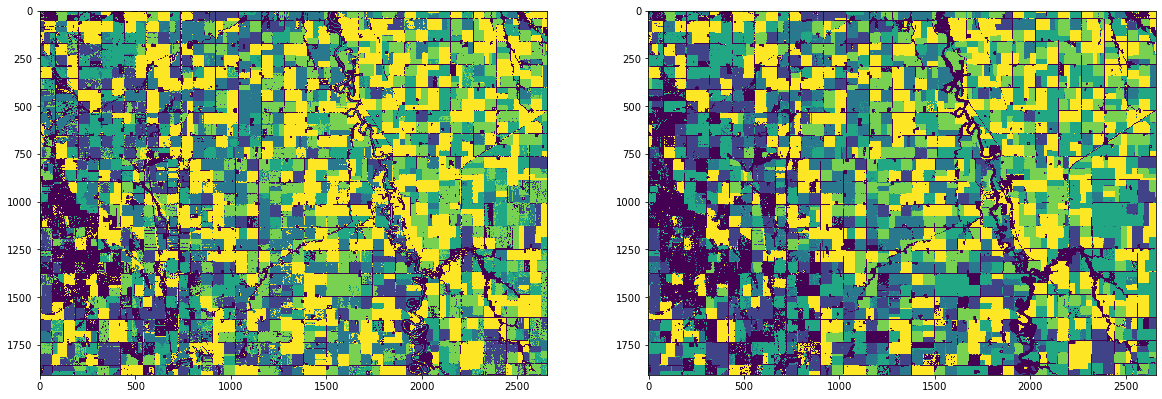

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].imshow(full_img)
axes[1].imshow(np.nan_to_num(cropsum))

<h2> See where it worked </h2>

In [92]:
difference_image = np.where(full_img == cropsum[:, 1:], 1, 0)

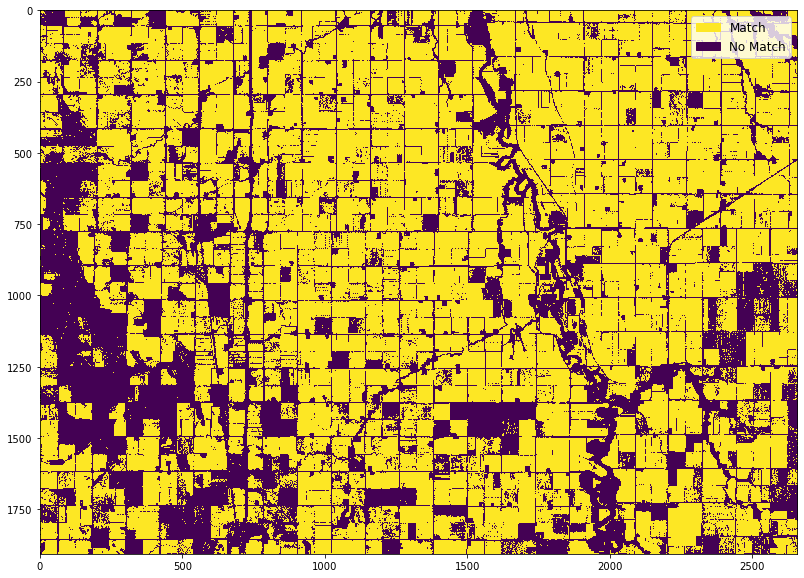

In [101]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(difference_image)
legend_items = [
                   patches.Patch(facecolor=cm.viridis(5/5), edgecolor=cm.viridis(5/5),
                         label='Match'),
                   patches.Patch(facecolor=cm.viridis(0/5), edgecolor=cm.viridis(0/5),
                         label='No Match')]
plt.legend(handles=legend_items, loc='top-left', prop={'size': 12})
plt.tight_layout()

Most of the no-math pixels are within areas of No-Data in the CropMap. This could be im proved by masking the array to predict to pixels that are valid in the crop map. 